# Study of the ROC-curve for the plausibility

---

The objective is to compare the AUC score with a max and avg head agregation

In [30]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

from os import path

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir
from torch.utils.data import DataLoader

from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_flow import attention_flow_max

from attention_algorithms.raw_attention import normalize_attention
from attention_algorithms.attention_metrics import plot_roc_vurve, visu_conf_mat

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "roc_curves")
if not path.exists(path.join(plots_folder, "roc_curves")):
    os.mkdir(path.join(plots_folder, "roc_curves"))

print(f">> the plots location : {graph_folder}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\roc_curves


In [31]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [32]:
# load the data
# load some data just load one sentence
data_set = SnliDataset(dir=test_dir, nb_sentences=500, msg=False)
data_loader = DataLoader(data_set, batch_size=500, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")

>> shape of the sentences : torch.Size([500, 150])
>> shape of the masks : torch.Size([500, 150])


In [33]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal"]]
e_snli_data.head()

,tok_sent,hg_goal
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Test with the max head agregation

In [97]:
class LenException(Exception):
    pass

class ConstructionError(Exception):
    pass

Y_test = []
probs = []
nb_err = 0
for i in range(50):
    j = 0
    # iteration through all the sentences
    # construct the raw attention object
    sent = torch.tensor([sentences[i, :].detach().numpy()])
    mk = torch.tensor([masks[i, :].detach().numpy()])
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # maximum agregation for the heads
    raw_attention_inst.set_up_graph(agr_type="max")

    try :
        while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            j+=1

        if j>=e_snli_data.shape[0]:
            raise LenException
        else :
            flow = attention_flow_max(raw_attention_inst)
            flow = normalize_attention(raw_attention_inst.tokens , torch.tensor(flow))
            probs += flow
            Y_test += eval(e_snli_data["hg_goal"][j])

    except LenException :
        # count the different errors
        nb_err += 1



print(f">> nb_errors {nb_err}")

print(f">> len Y_test {len(Y_test)}")
print(f">> len probs {len(probs)}")

>> nb_errors 1
>> len Y_test 1303
>> len probs 1303


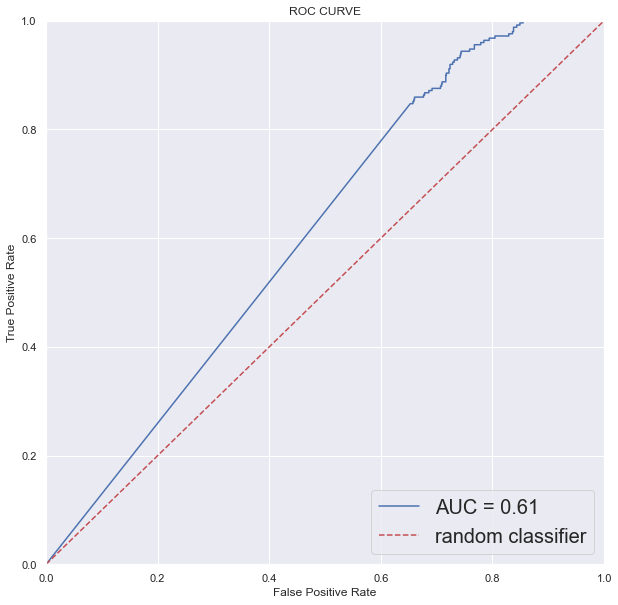

In [98]:
_ = plot_roc_vurve(Y_test , probs)

## Test with the avg heads agregation

In [95]:
class LenException(Exception):
    pass

class ConstructionError(Exception):
    pass

Y_test = []
probs = []
nb_err = 0
for i in range(50):
    j = 0
    # iteration through all the sentences
    # construct the raw attention object
    sent = torch.tensor([sentences[i, :].detach().numpy()])
    mk = torch.tensor([masks[i, :].detach().numpy()])
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # maximum agregation for the heads
    raw_attention_inst.set_up_graph(agr_type="avg")

    try :
        while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            j+=1

        if j>=e_snli_data.shape[0]:
            raise LenException
        else :
            flow = attention_flow_max(raw_attention_inst)
            flow = normalize_attention(raw_attention_inst.tokens , torch.tensor(flow))
            probs += flow
            Y_test += eval(e_snli_data["hg_goal"][j])

    except LenException :
        # count the different errors
        nb_err += 1



print(f">> nb_errors {nb_err}")

print(f">> len Y_test {len(Y_test)}")
print(f">> len probs {len(probs)}")

>> nb_errors 1
>> len Y_test 1303
>> len probs 1303


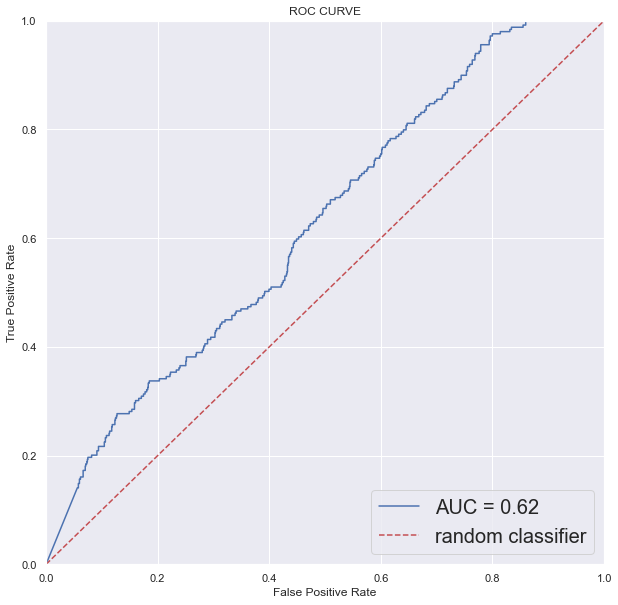

In [96]:
_ = plot_roc_vurve(Y_test , probs)